We look to compute traveling wave solutions of

\begin{align*}
u_t + 6 uu_x + u_{xxx} = 0.
\end{align*}

We have seen that for $c \in \mathbb R$, we should consider the boundary-value problem

\begin{align*}
 \begin{cases}
 c w'(x) + \sigma w(x) w'(x) + w'''(x) = 0,\\
 w(0) = w(L),\\
 w'(0) = w'(L),\\
 w''(0) = w''(L).
 \end{cases}
\end{align*}

We are interested in the case where $\sigma = 1$.  But it will be convenient to use this as a continuation parameter.

Instead of considering the periodic boundary conditions, we add appropriate conditions to make a well-posed BVP when $\sigma = 0$: $L = 1$, $c = k^2 \pi^2$:

\begin{align*}
 \begin{cases}
 c w'(x) + w'''(x) = 0,\\
 w(0) = 0,\\
 w(L) = 0,\\
     w'(L) = \beta.
 \end{cases}
\end{align*}

In [3]:
using LinearAlgebra, SparseArrays, FiniteDifferences, Plots

In [4]:
m = 4999;
L = 1;
k = 3
β = k*pi*(-1)^k
c = k^2*pi^2
h = L/(m+1); #grid spacing depends on interval length
xs = h:h:L-h

0.0002:0.0002:0.9998

In [5]:
u = x -> sin.(k*pi*x)

#1 (generic function with 1 method)

In [6]:
method = FiniteDifferenceMethod([-1, 0, 1], 1)
display(method)
first = method.coefs |> Vector

FiniteDifferenceMethod:
  order of method:       3
  order of derivative:   1
  grid:                  [-1, 0, 1]
  coefficients:          [-0.5, 0.0, 0.5]


3-element Vector{Float64}:
 -0.5
  0.0
  0.5

In [7]:
method = FiniteDifferenceMethod([-1, 0, 1, 2, 3], 3)
display(method)
left = method.coefs |> Vector

FiniteDifferenceMethod:
  order of method:       5
  order of derivative:   3
  grid:                  [-1, 0, 1, 2, 3]
  coefficients:          [-1.5, 5.0, -6.0, 3.0, -0.5]


5-element Vector{Float64}:
 -1.5
  5.0
 -6.0
  3.0
 -0.5

In [8]:
method = FiniteDifferenceMethod([-2,-1, 0, 1, 2], 3)
display(method)
third = method.coefs |> Vector

FiniteDifferenceMethod:
  order of method:       5
  order of derivative:   3
  grid:                  [-2, -1, 0, 1, 2]
  coefficients:          [-0.5, 1.0, 0.0, -1.0, 0.5]


5-element Vector{Float64}:
 -0.5
  1.0
  0.0
 -1.0
  0.5

In [9]:
method = FiniteDifferenceMethod([-2,-1, 0,1], 1)
display(method)
right = method.coefs |> Vector

FiniteDifferenceMethod:
  order of method:       4
  order of derivative:   1
  grid:                  [-2, -1, 0, 1]
  coefficients:          [0.16666666666666666, -1.0, 0.5, 0.3333333333333333]


4-element Vector{Float64}:
  0.16666666666666666
 -1.0
  0.5
  0.3333333333333333

In [10]:
bD = zeros(m)
D = Tridiagonal(fill(-1.0,m-1), fill(0.0,m), fill(1.0,m-1));
D = sparse(D);
D *= 0.5/h;

In [11]:
# bD3 = zeros(m)
# D3 = spzeros(m,m)
# D3[1,1:4] = left[2:end]
# D3[2,1:4] = third[2:end]
# D3[end-1,end-3:end] = third[1:end-1]
# D3[end,end-2:end] = third[1:end-2]
# for i = 3:m-2
#    D3[i,i-2:i+2] = third
# end
# vec = -right[1:end-2]/right[end]
# D3[end,end-2:end] += 0.5*vec
# D3 *= 1/h^3

# bD3[end] -= 0.5*β*h/right[end]
# bD3 *= 1/h^3;

bD3 = zeros(m)
D3 = spzeros(m,m)
D3[1,1:4] = left[2:end]
D3[2,1:4] = third[2:end]
D3[end-1,end-3:end] = third[1:end-1]
D3[end,end-2:end] = third[1:end-2]
for i = 3:m-2
   D3[i,i-2:i+2] = third
end
vec = -right[1:2]/right[end]
D3[end,end-1:end] += 0.5*vec
D3 *= 1/h^3

bD3[end] -= 0.5*β*h/right[end]
bD3 *= 1/h^3;

In [18]:
D3[1:5,1:5]*(4h^3) |> Array

5×5 Matrix{Float64}:
 20.0  -24.0  12.0  -2.0   0.0
  4.0    0.0  -4.0   2.0   0.0
 -2.0    4.0   0.0  -4.0   2.0
  0.0   -2.0   4.0   0.0  -4.0
  0.0    0.0  -2.0   4.0   0.0

In [16]:
D3[end-5:end,end-5:end]*(4h^3)

6×6 SparseMatrixCSC{Float64, Int64} with 19 stored entries:
   ⋅   -4.0   2.0    ⋅     ⋅     ⋅ 
  4.0    ⋅   -4.0   2.0    ⋅     ⋅ 
 -2.0   4.0    ⋅   -4.0   2.0    ⋅ 
   ⋅   -2.0   4.0    ⋅   -4.0   2.0
   ⋅     ⋅   -2.0   4.0    ⋅   -4.0
   ⋅     ⋅     ⋅   -2.0   3.0   6.0

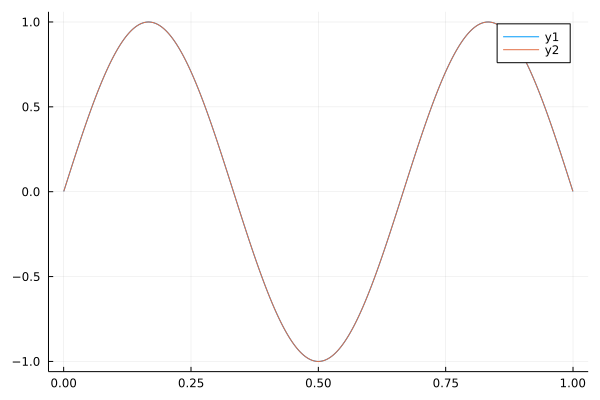

In [159]:
U = (c*D + D3)\(c*bD + bD3);
plot(xs,U)
plot!(xs,u(xs))

In [160]:
maximum(abs.(U - u(xs)))

9.302891149918276e-7

# Continuation in the nonlinear case

We use $\circ$ to denote entrywise vector multiplication.  Our approximation of

$$ W \mapsto F(W) := c W'(x) + \sigma W(x) W'(x) + W'''(x) $$

in vector form is given by

$$ \vec W \mapsto  F_m(\vec W):= c D \vec W +  (D \vec W) \circ \vec W + D_3 \vec W.$$

In [161]:
Fm = (W,σ) -> c*(D*W) + σ*(D*W).*W + (D3*W) - (c*bD + bD3)

#11 (generic function with 1 method)

Since we are solving a nonlinear problem, we need to do some sort of root-finding.  We will use Newton's method, and therefore, we need to compute the Jacobian.


$$
  D_{\vec W} F_m(\vec W) = \frac{c}{h} D + \frac{1}{h} \mathrm{diag}(D \vec W) + \frac{1}{h} \mathrm{diag}(\vec W)D + \frac{1}{h^3} D_3 .
$$

In [162]:
DFm = (W,σ) -> c*D + D3 + σ*Diagonal(D*W) + σ*Diagonal(W)*D

#13 (generic function with 1 method)

In [163]:
W = zeros(m);
σ = 0.0;

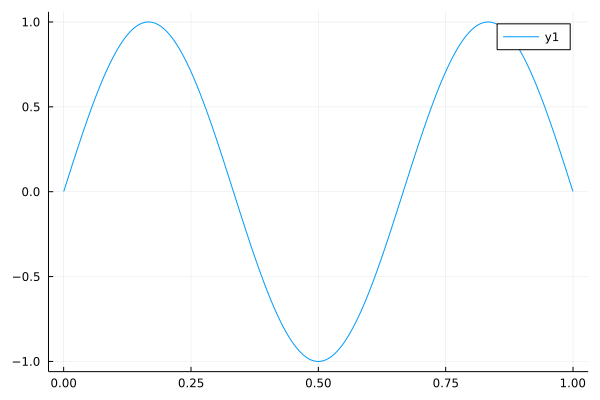

In [164]:
W = W - DFm(W,σ)\Fm(W,σ);
plot(xs,W)

In [165]:
σ_step = 10.0
σ = 0
W = zeros(m);
p = plot()
for σ = 0:σ_step:60
    count = 0
    update = fill(100,m)
    while maximum(abs.(update)) > 1e-10
        count += 1
        update = DFm(W,σ)\Fm(W,σ)
        W = W - update
        #print(maximum(abs.(update)))
        if count == 300
            print("No convergence: ")
            println(σ)
            break
        end
    end
    plot!(xs,W,legend=:outerright, label = string(σ))
end

No convergence: 40.0


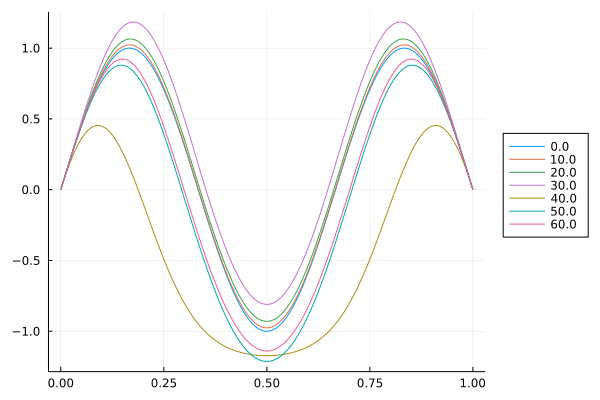

In [166]:
p

In [167]:
maximum(abs.(Fm(W,60)))

6.130860455755283e-5